In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

# Custom imports
%run -i ../fix_path.py
from stepbystep.v0 import StepByStep

## Data Generation
Creating a dataset for binary classification. In the target column, 0: red, 1: blue

In [2]:
X, y = make_moons(n_samples=100, noise=0.1, random_state=0)

In [3]:
X[:4], y[:4]

(array([[-0.05348369,  0.99258199],
        [ 1.81989987, -0.17559999],
        [ 0.95535658,  0.05999942],
        [ 0.01558147,  0.11081703]]),
 array([0, 1, 0, 1]))

## Visualizing our data
As can be seen in the diagram below, we have two crescent moons that kind of interlock, a perfect example of non-linear data for binary classification

In our `make_moons` dataset, for any point, like X[0], the first value is the x-axis and the second values is the y-axis

- `X[:,0]` → horizontal position of each point (x-axis).

- `X[:,1]` → vertical position of each point (y-axis).

- `c=y` → color of each point depends on its class (label).

  - Points with label 0 get one color.

  - Points with label 1 get another.

- `cmap=plt.cm.Paired` → chooses a color map (a set of colors).

  - Paired gives nicely contrasting colors, like blue and orange.

- `edgecolor="black"` → draws a black outline around each point.

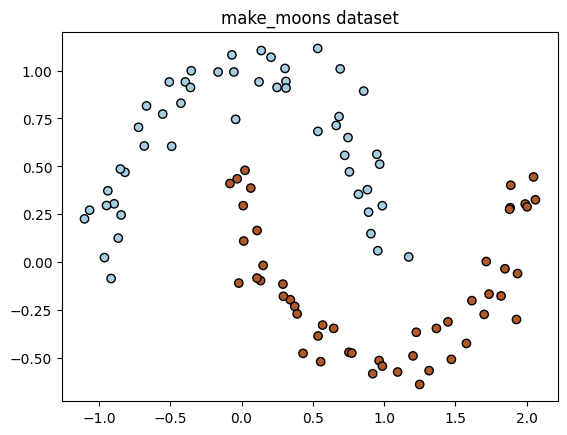

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="black")
plt.title("make_moons dataset")
plt.show()

## Train-Validation Split
Remember, the split should be the very first thing you do - no pre-processing, no transformations, nothing happens before the split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

## Standardize Features

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

## Data Preparation
- Converting NumPy arrays to PyTorch Tensors
- Creating a TensorDataset 
- Creating DataLoaders

In [7]:
y_train[:4], y_train[:4].reshape(-1, 1)

(array([1, 1, 1, 0]),
 array([[1],
        [1],
        [1],
        [0]]))

In [8]:
# Converting NumPy array to Tensors
x_train_tensor = torch.as_tensor(X_train_scaled).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val_scaled).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Creating a TensorDataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Creating DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [9]:
torch.manual_seed(42)
model1 = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)
model1.state_dict()

OrderedDict([('0.weight', tensor([[0.5406, 0.5869]])),
             ('0.bias', tensor([-0.1657]))])

## Problem with using log + sigmoid as used in `BCELoss`

In [10]:
import numpy as np
np.log2(8)

np.float64(3.0)

In [11]:
(np.log(9) / np.log(3)) * -1

np.float64(-2.0)

In [12]:
-np.log(1)

np.float64(-0.0)

In [13]:
-np.log(0.9)

np.float64(0.10536051565782628)

In [14]:
torch.log(torch.tensor(0.0))

tensor(-inf)

In [15]:
import torch
import torch.nn as nn

# extreme logits
z = torch.tensor([-100.0, 0.0, 100.0])
y = torch.tensor([0.0, 1.0, 1.0])

# 1️⃣ Unstable manual BCE
# As you can see in the results below, as the values of z grows larger leading to P (sigmoid) close or equal to 0 or 1.
# torch.log(P) yields -inf thus instability. i.e, torch.log(0) = -inf (This is the instability)
sigmoid = torch.sigmoid(z)
print(f"Sigmoid (Probabilities): {sigmoid}")
manual_bce = -(y * torch.log(sigmoid) + (1 - y) * torch.log(1 - sigmoid))
print("Manual BCE:\n", manual_bce)

# 2️⃣ Stable BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(reduction='none')
stable_bce = criterion(z, y)
print("\nBCEWithLogitsLoss:\n", stable_bce)


Sigmoid (Probabilities): tensor([0.0000, 0.5000, 1.0000])
Manual BCE:
 tensor([   nan, 0.6931,    nan])

BCEWithLogitsLoss:
 tensor([0.0000e+00, 6.9315e-01, 3.9236e-44])


## Handling Class Imbalance in Pytorch using `WeightedRandomSampler`

In [16]:
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
torch.manual_seed(42)

# Example dataset
labels = torch.tensor([0, 0, 0, 1])  # 3 negatives, 1 positive
features = torch.randn(4, 2)
dataset = TensorDataset(features, labels)
features, labels

(tensor([[ 0.3367,  0.1288],
         [ 0.2345,  0.2303],
         [-1.1229, -0.1863],
         [ 2.2082, -0.6380]]),
 tensor([0, 0, 0, 1]))

In [17]:
# Compute class counts
class_counts = torch.bincount(labels) # [3, 1] -> 0: 3, 1: 1
print(f"Class Counts: {class_counts.tolist()}")

# Compute the class weights (We take the inverse of the class counts)
# Why the inverse? So that the minority class gets higher weights
class_weights = 1.0 / class_counts.float()
print(f"Class Weights: {class_weights.tolist()}")

Class Counts: [3, 1]
Class Weights: [0.3333333432674408, 1.0]


In [18]:
# Assign weights to each sample depending on it's class
# PyTorch uses tensor indexing, which means:
# For each element l in labels, pick class_weights[l]
sample_weights = class_weights[labels]
print(f"Sample Weights: {sample_weights.tolist()}")

Sample Weights: [0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 1.0]


In [19]:
# Create a Sampler
# WeightedRandomSampler allows you to assign a weight (probability) to each sample.
# Samples with higher weights are more likely to be chosen when drawing from the dataset during training.
# In simple words, samples with a higher weights are more likely to be picked for each batch during training.
sampler = WeightedRandomSampler(
    weights=sample_weights, # a tensor containing weights for each sample
    num_samples=len(sample_weights), # how many samples per epoch. Reduce this for larger datasets, e.g 0.25 * len(sample_weights)
    replacement=True # repeat samples (Allows samples to appear more than once per epoch. Good for the minority class)
)

In [20]:
# Create the DataLoader
loader = DataLoader(dataset=dataset, batch_size=16, sampler=sampler)

## Let's define a model that outputs logits (these are simply linear models, i.e nn.Linear()) and use `BCEWithLogitsLoss` on it

In [21]:
# Model Configuration
lr = 0.1
torch.manual_seed(42)
model = nn.Sequential(
    nn.Linear(2, 1)
)

optimizer = optim.SGD(params=model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss()

In [22]:
# Model Training
n_epochs = 100
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

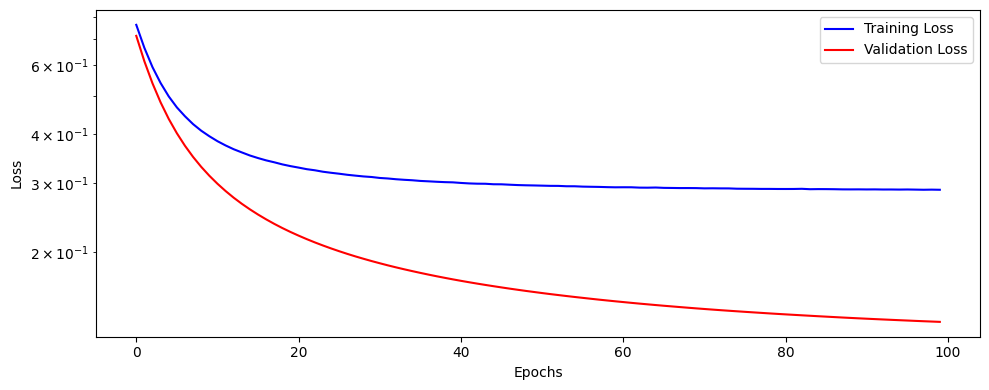

In [23]:
fig = sbs.plot_losses()

In [24]:
model.state_dict()

OrderedDict([('0.weight', tensor([[ 1.0506, -2.3214]])),
             ('0.bias', tensor([-0.0740]))])

In [25]:
# Logits
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.12383821],
       [ 4.1313004 ],
       [ 3.9159667 ],
       [-0.6568495 ]], dtype=float32)

In [26]:
# Probabilities
probabilities = torch.sigmoid(torch.as_tensor(predictions).float())
probabilities, y_train_tensor[:4]

(tensor([[0.5309],
         [0.9842],
         [0.9805],
         [0.3414]]),
 tensor([[1.],
         [1.],
         [1.],
         [0.]]))

In [27]:
# From probabilities to classes
classes = (probabilities >= 0.5).int()
classes, y_train_tensor[:4]

(tensor([[1],
         [1],
         [1],
         [0]], dtype=torch.int32),
 tensor([[1.],
         [1.],
         [1.],
         [0.]]))

In [28]:
model.state_dict()

OrderedDict([('0.weight', tensor([[ 1.0506, -2.3214]])),
             ('0.bias', tensor([-0.0740]))])

In [29]:
# Evaluation
logits_val =torch.as_tensor(sbs.predict(X_val)).float()
probabilities_val = torch.sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))

In [30]:
cm_thresh50

array([[ 8,  1],
       [ 1, 10]])

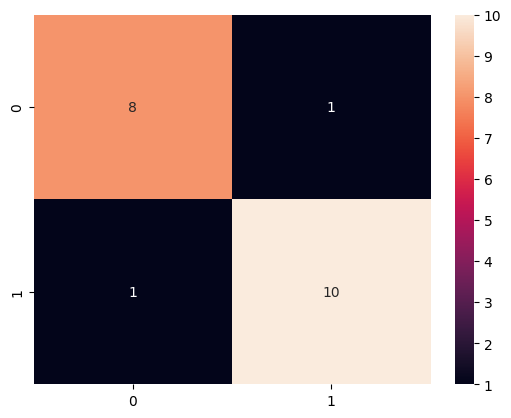

In [31]:
from seaborn import heatmap
heatmap(cm_thresh50, annot=True)
plt.show()

In [32]:
from sklearn.metrics import accuracy_score
y_pred = (probabilities_val >= 0.5)
acc = accuracy_score(y_val_tensor, y_pred)
print(f"Accuracy score: {acc}")

Accuracy score: 0.9
